In [1]:
import supervisely_lib as sly
import cv2
import os.path as osp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Any supervisely programm contain folders: "model", "result", "data", "tmp". Also, it has file task_settings.json
task_paths = sly.TaskPaths() # now task_paths contain paths to all this folders and file
project_dir = task_paths.project_dir
# Any folder "data" contain project with images and some meta information in file meta.json
project_meta = sly.ProjectMeta.from_dir(project_dir) # read info from meta.json

In [3]:
# meta.json contain info about classes in annotations of images
# including a color corresponding to each class 
color_mapping = {} # this variable will contain a mapping class->color
for cls_descr in project_meta.classes:
    color_s = cls_descr.get('color')
    if color_s is not None:
        color = sly.hex2rgb(color_s)  # use color from project meta if exists
    else:
        color = sly.get_random_color()  # or use random color otherwise
    color_mapping[cls_descr['title']] = color

In [4]:
# Now we need to load images with there annotations
fs = sly.ProjectFS.from_disk(*sly.ProjectFS.split_dir_project(project_dir))
# And create an output project structure 'project_augmentations'
out_pr_structure = sly.ProjectStructure('project_augmentations')

In [5]:
# Add items to output project structure
# Each item contain info about dataset_name and some service information
# about images and annotations
for sample_info in fs:
    sample_data = sample_info.ia_data
    dt = {
        'src_img_path': sample_info.img_path,
        'ann_img_path': sample_info.ann_path,
        **sample_data
    }
    out_pr_structure.add_item(sample_info.ds_name, sample_info.image_name, dt)

In [6]:
# Using output projects structure `out_pr_structure` we create
#  folders corresponding to this structure
out_pr_fs = sly.ProjectFS(task_paths.results_dir, out_pr_structure)
out_pr_fs.make_dirs()

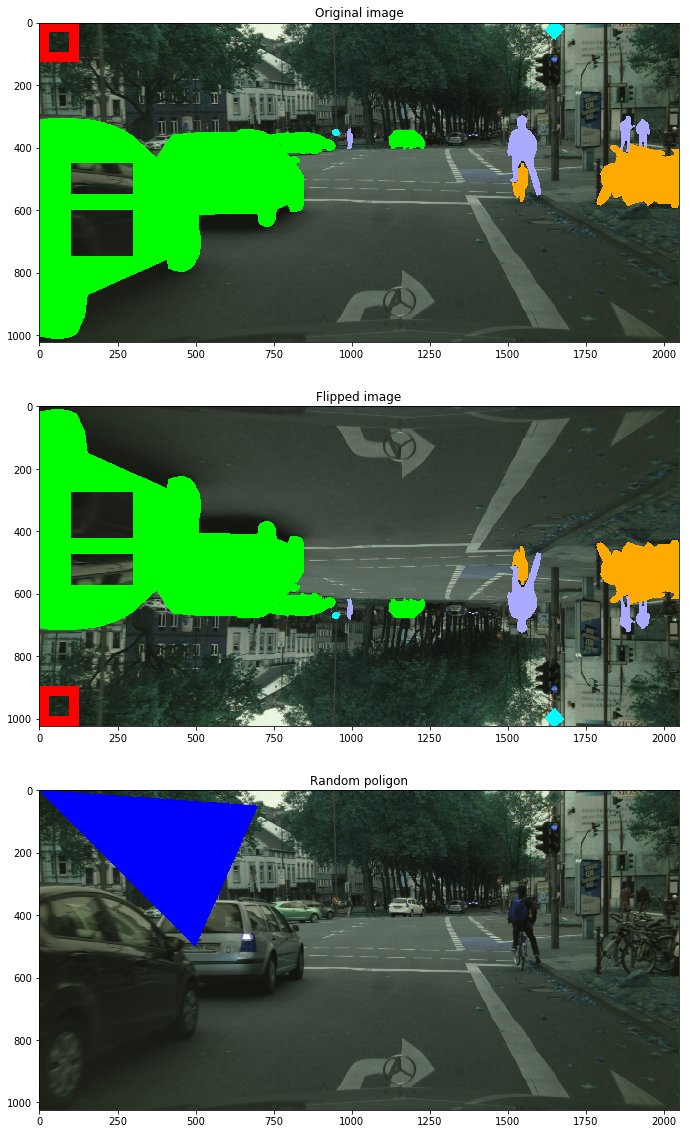

In [7]:
# Loop throw output project file structure
plt.figure(figsize=(20, 20))
for s in out_pr_fs:
    ann_packed = sly.json_load(s.ia_data['ann_img_path'])
    ann = sly.Annotation.from_packed(ann_packed, project_meta) # Unpack annotation
    if len(ann['objects']) > 0:
        img = cv2.imread(s.ia_data['src_img_path'])
        img_flip = img[::-1, :, :]
        img_pol = img.copy()
        for obj in ann['objects']:
            obj.draw(img, color_mapping[obj.data['classTitle']])
        ax = plt.subplot(3, 1, 1)
        ax.set_title('Original image')
        plt.imshow(img)
        # flip
        for obj in ann['objects']:
            obj.flip(True, (img_flip.shape[0],img_flip.shape[1]))
        ax = plt.subplot(3, 1, 2)
        ax.set_title('Flipped image')
        plt.imshow(img_flip)
        # poligon
        plg = sly.FigurePolygon.from_np_points("rand_poligon", (img_flip.shape[0],img_flip.shape[1]), [[0,0], [200, 200], [500, 500], [700,50]], [])
        plg[0].draw(img_pol, [0,0,255])
        ax = plt.subplot(3, 1, 3)
        ax.set_title('Random poligon')
        plt.imshow(img_pol)
plt.show()